In [1]:
import geopandas as gpd
from pathlib import Path

import sys
sys.path.insert(0, '../../geocoded_object_extractor')
from geocoded_object_extractor import TreeDataset
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray
import xarray as xr

In [2]:
path_rgb = '../../../data/Fieldwork_data/PNM/PROCESSADOS/Map1_Orthomosaic_export_SatJun10172428194829.tif'
path_bbox = '../../../data/Tree_location1.gpkg'

In [3]:
def _is_round(row, num_vertex=10):
    # Polygons with >num_vertex vertex are considered to be round 
    return len(list(row['geometry'].exterior.coords))>num_vertex

In [4]:
tree_locs = gpd.read_file(path_bbox)
# Select squares from the tree labels
gdf_tree_bbox = tree_locs.where(~tree_locs.apply(_is_round, axis=1)).dropna(how='all')
gdf_tree_bbox

,ID,ESPECIE,TIPO,SELECIONADA PROJETO,geometry
0,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331065.955 7366756.421, 331065.955 7..."
1,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331068.069 7366779.140, 331068.069 7..."
2,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331075.623 7366793.023, 331075.623 7..."
3,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331088.034 7366814.640, 331088.034 7..."
7,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331133.179 7366823.083, 331133.179 7..."
8,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331196.087 7366842.868, 331196.087 7..."
9,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331196.075 7366878.784, 331196.075 7..."
10,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331197.649 7366907.473, 331197.649 7..."
11,0.0,Archontophoenix cunninghamiana,exotica invasora,SIM,"POLYGON ((331201.764 7366898.142, 331201.764 7..."
25,NaN,Araucaria angustifolia,ameacada,SIM,"POLYGON ((331278.924 7366884.942, 331278.924 7..."


In [5]:
img = rioxarray.open_rasterio(path_rgb)
gdf_tree_bbox = gdf_tree_bbox.set_crs(img.rio.crs)

In [6]:
classes = pd.DataFrame(0, columns=['label'], index=gdf_tree_bbox.index)

In [7]:
ds = TreeDataset([path_rgb],gdf_tree_bbox['geometry'], classes['label'], augment_data=False, min_pixel_size=50, max_pixel_size=400, pixel_size=400)

In [8]:
tiles = ds.get_cutouts()

In [9]:
ds = xr.Dataset(
    data_vars={
        "X": (["sample", "x", "y", "channel"], tiles[2]),
        "Y": (["sample"], tiles[1]),
    }
)
ds

<xarray.Dataset>
Dimensions:  (sample: 12, x: 400, y: 400, channel: 4)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Y        (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0

Text(0.5, 1.0, 'True class 0')

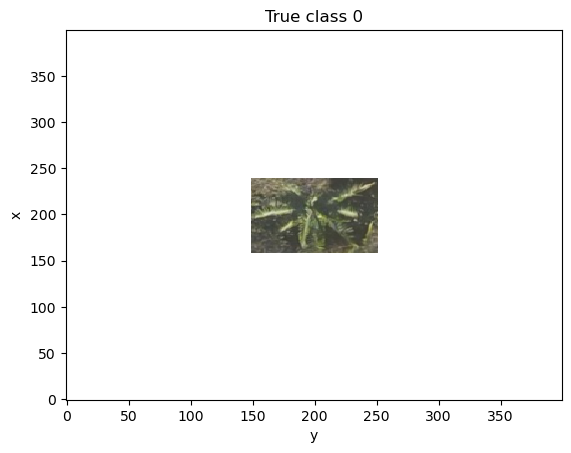

In [10]:
# Visualize the test sample
test_sample = ds.isel(sample=2)
test_sample['X'].astype('int').plot.imshow()
plt.title(f"True class {test_sample['Y'].values.astype('str')}")

In [11]:
ds.to_zarr('brazil_cutouts.zarr')